In [21]:
import pandas as pd
from nltk.corpus import stopwords
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score,classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB


In [22]:
path_in = "twitterClimateData.csv"
df = pd.read_csv(path_in, delimiter=";")
df = df.sample(40000)
df = df[pd.notnull(df["text"])].reset_index(drop=True)
df.head(3)

,Unnamed: 0,id,author_id,text,retweets,permalink,date,formatted_date,favorites,mentions,hashtags,geo,urls,search_hashtags,location
0,58827,1.12914e+18,2.970636e+09,Peter doing his bit on the last day before the...,0,https://twitter.com/Cubaclarita/status/1129144...,2019-05-16 22:01:13+00:00,Thu May 16 22:01:13 +0000 2019,0,NaN,#ausvote #election2019 #auspol #australiavotes...,NaN,https://www.instagram.com/p/BxihAw3FcMu/?igshi...,#climatechange,"Sydney, Australia"
1,31428,1.13082e+18,9.080000e+17,“We can create amazing recreational areas that...,0,https://twitter.com/KristinKMA/status/11308186...,2019-05-21 12:52:35+00:00,Tue May 21 12:52:35 +0000 2019,3,@cookrobinchris @CityOfBoston @EmNecklaceBos,#equity #ClimateAction,NaN,NaN,#climateaction,"Florida, USA"
2,37881,1.17492e+18,3.006099e+08,#ClimateStrike. Melbourne. Please just start t...,0,https://twitter.com/CLang13/status/11749181253...,2019-09-20 05:28:04+00:00,Fri Sep 20 05:28:04 +0000 2019,0,NaN,#ClimateStrike,NaN,NaN,#climatestrike,"Melbourne, Australia"


In [23]:
from io import StringIO
col = ['search_hashtags', 'text']
df = df[col]
df = df[pd.notnull(df['text'])]
df.columns = ['search_hashtags', 'text']
df['hashtags_id'] = df['search_hashtags'].factorize()[0]
category_id_df = df[['search_hashtags', 'hashtags_id']].drop_duplicates().sort_values('hashtags_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['hashtags_id', 'search_hashtags']].values)
df.head()

,search_hashtags,text,hashtags_id
0,#climatechange,Peter doing his bit on the last day before the...,0
1,#climateaction,“We can create amazing recreational areas that...,1
2,#climatestrike,#ClimateStrike. Melbourne. Please just start t...,2
3,#savetheplanet,It’s the first day of fall and it’s going to b...,3
4,#climatestrike,#Strike4Climate #ClimateStrike,2


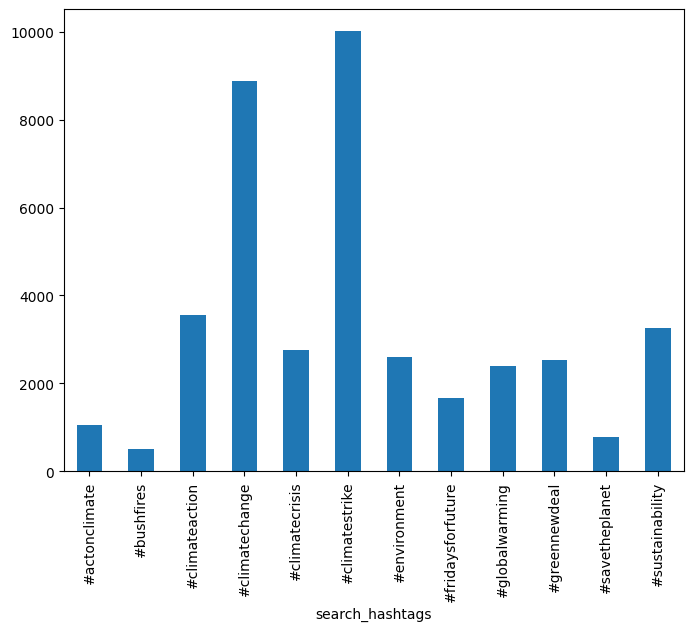

In [24]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('search_hashtags').text.count().plot.bar(ylim=0)
plt.show()

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2',  ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.text).toarray()
labels = df.hashtags_id
features.shape

(40000, 26225)

In [26]:
features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [27]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for search_hashtags, hashtags_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == hashtags_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(search_hashtags))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# '#actonclimate':
  . Most correlated unigrams:
. 100by50
. actonclimate
  . Most correlated bigrams:
. actonclimate climateactionnow
. allarecalled actonclimate
# '#bushfires':
  . Most correlated unigrams:
. smoke
. bushfires
  . Most correlated bigrams:
. bushfires auspol
. auspol bushfires
# '#climateaction':
  . Most correlated unigrams:
. sdgs
. climateaction
  . Most correlated bigrams:
. united nations
. climatechange climateaction
# '#climatechange':
  . Most correlated unigrams:
. climatestrike
. climatechange
  . Most correlated bigrams:
. climatechange real
. auspol climatechange
# '#climatecrisis':
  . Most correlated unigrams:
. climatestrike
. climatecrisis
  . Most correlated bigrams:
. climateemergency climatecrisis
. climatechange climatecrisis
# '#climatestrike':
  . Most correlated unigrams:
. climatechange
. climatestrike
  . Most correlated bigrams:
. climatestrike climateaction
. today climatestrike
# '#environment':
  . Most correlated unigrams:
. birchfabrics


In [28]:
#For Train set

#Term Frecuency - TF 
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(df['text'])

#TF - IDF
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

In [29]:
# Naive Bayes Classifier: the one most suitable for word counts is the multinomial variant:

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['search_hashtags'], random_state = 0)

In [30]:
clf = MultinomialNB().fit(X_train, y_train)
print(clf)

MultinomialNB()


In [31]:
# Naive Bayes Classifier: the one most suitable for word counts is the multinomial variant:

import pickle

pickle.dump(clf,open("file.model","wb"))

#clf = pickle.load(open("file.model", 'rb'))
result = clf.score(X_test, y_test)
result

0.4581

## validación del modelo

In [32]:
y_pred = clf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average="macro"))

Accuracy: 0.4581
F1 score: 0.19332009290217944


In [33]:
print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

    #actonclimate       1.00      0.01      0.01       268
       #bushfires       0.00      0.00      0.00       134
   #climateaction       0.79      0.04      0.08       872
   #climatechange       0.36      0.81      0.49      2206
   #climatecrisis       1.00      0.03      0.05       686
   #climatestrike       0.52      0.94      0.67      2523
     #environment       0.76      0.10      0.18       653
#fridaysforfuture       0.94      0.04      0.07       428
   #globalwarming       0.79      0.10      0.17       559
    #greennewdeal       0.95      0.11      0.20       642
   #savetheplanet       1.00      0.02      0.04       205
  #sustainability       0.90      0.20      0.33       824

         accuracy                           0.46     10000
        macro avg       0.75      0.20      0.19     10000
     weighted avg       0.66      0.46      0.36     10000



/home/dalopeza/.local/share/virtualenvs/Trabajo2_almdatos-ai3jCzIO/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dalopeza/.local/share/virtualenvs/Trabajo2_almdatos-ai3jCzIO/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dalopeza/.local/share/virtualenvs/Trabajo2_almdatos-ai3jCzIO/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze